Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
#Connect to google drive to get an access to the dataset, if required
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Suppress tensorflow warnings. Only log the errors
import logging
tf.get_logger().setLevel(logging.ERROR)


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
#unzip the dataset, if required
# !unzip '/CNN_assignment.zip' -d '/Melanoma_detection/'

Archive:  /content/drive/MyDrive/Colab Notebooks/CNN_assignment.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Melan

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Images available in train dataset:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Images available in test dataset:", image_count_test)

Images available in train dataset: 2239
Images available in test dataset: 118


In [5]:
#considering some predefined inputs from the assignment
batch_size = 32
img_height = 180
img_width = 180
seed_val = 123

### Load using keras.preprocessing

Use 80% of the images for training, and 20% for validation.

In [6]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=seed_val,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writing the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=seed_val,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print("The different types of cancer classes are: ")
print(class_names)

The different types of cancer classes are: 
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

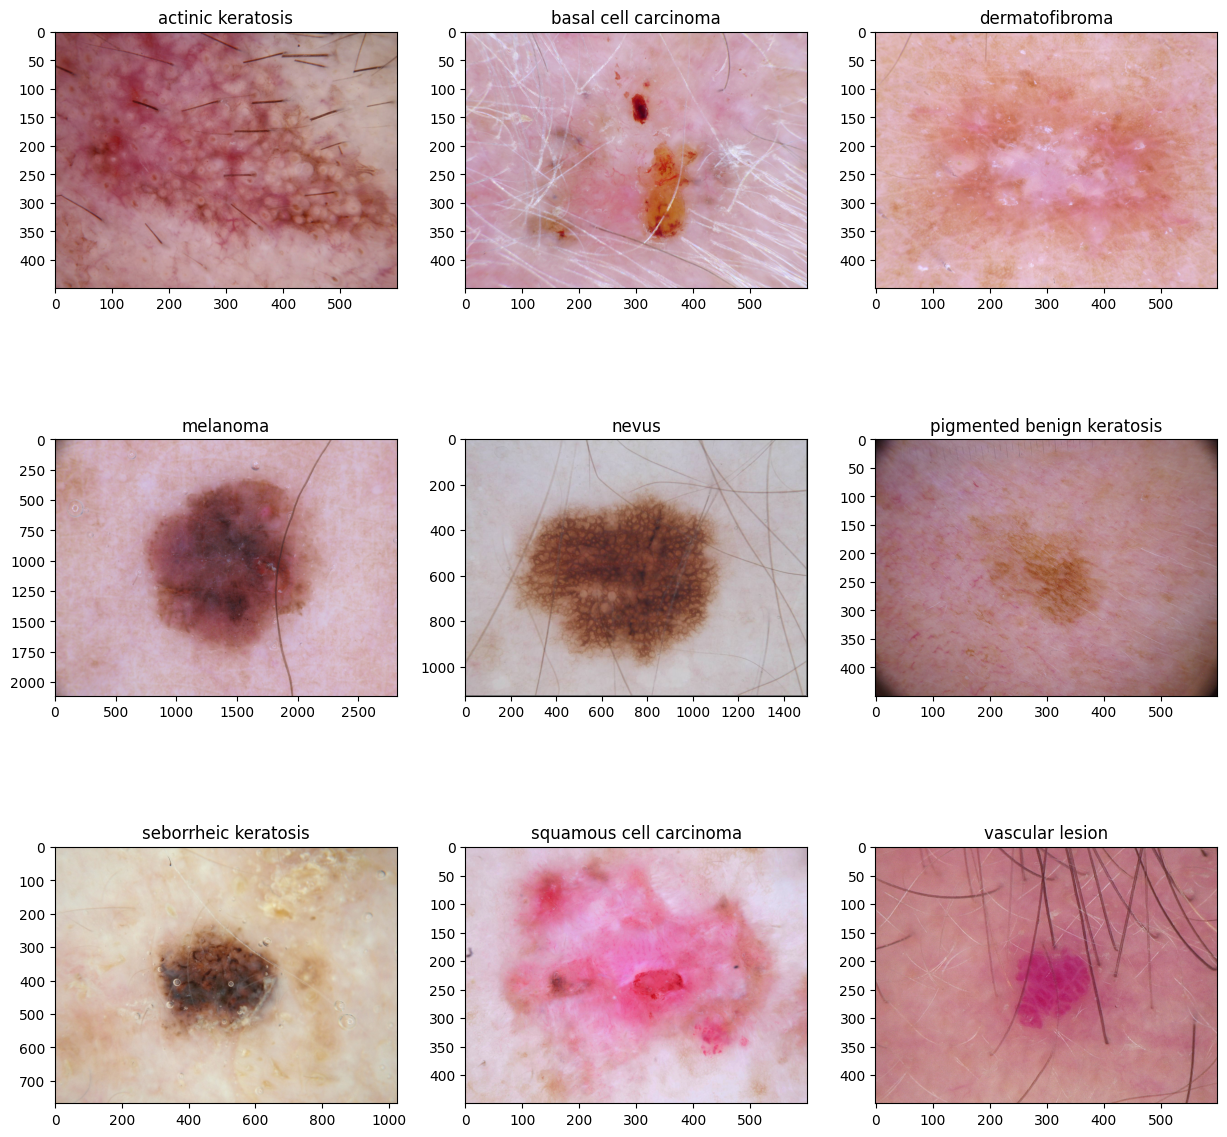

In [15]:
### visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(15,15))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the first model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range.

In [17]:
# CNN Model - Initial
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [18]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [19]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 33s 138ms/step - loss: 1.9904 - accuracy: 0.2885 - val_loss: 1.8012 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 1.6622 - accuracy: 0.4035 - val_loss: 1.5328 - val_accuracy: 0.4586
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 1.4641 - accuracy: 0.4821 - val_loss: 1.4060 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 1.4032 - accuracy: 0.5179 - val_loss: 1.4947 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 1.3529 - accuracy: 0.5385 - val_loss: 1.3564 - val_accuracy: 0.5570
Epoch 6/20
56/56 [==============================] - 3s 58ms/step - loss: 1.2090 - accuracy: 0.5809 - val_loss: 1.3619 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 1.1914 - accuracy: 0.5820 - val_loss: 1.6389 - val_accuracy: 0.4541
Epoch 8/20


In [20]:
#Method to visualize the training results

def visualize_cnn(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper center')
  plt.title('Training and Validation Loss')
  plt.show()

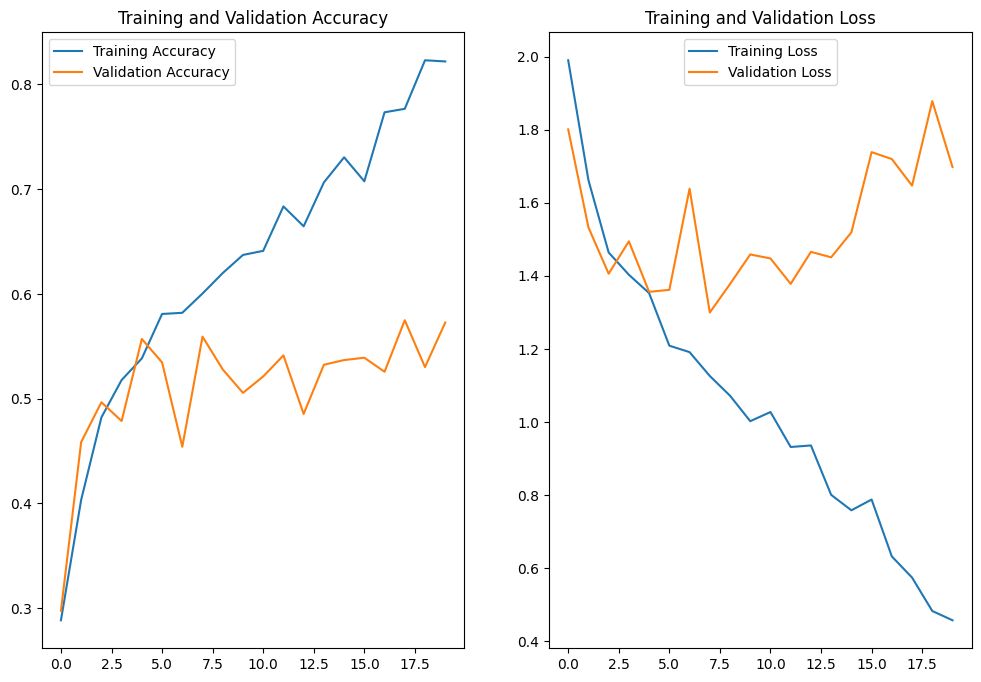

In [21]:
#visualize the training results
visualize_cnn(history, epochs)

### Observations:
1. As the number of epochs increase, the training accuracy increases whereas the validation accuracy increases to a max value of 50-55% and then stalls.
2. As the number of epochs increase, the training loss decreases whereas the validation loss decreases in the start but later keeps on increasing.
3. Overall, the validation accuracy was around **50-55%** for the model.
4. The high training accuracy and low validation accuracy tells us that <mark>**the model is Overfitting and needs tuning**</mark>.

### Conclusion:
Overfitting can happen due to several reasons, such as:

- The training data size is too small and does not contain enough data samples to accurately represent all possible input data values.
- The training data contains large amounts of irrelevant information, also called noisy data.
- The model trains for too long on a single sample set of data.
- The model complexity is high, so it learns the noise within the training data.

For our model, looks like the training data is insufficient. So, let's try to perform some data augmentation strategy to come up with a bigger dataset

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

In [22]:
#Performing data augmentation on the training dataset
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

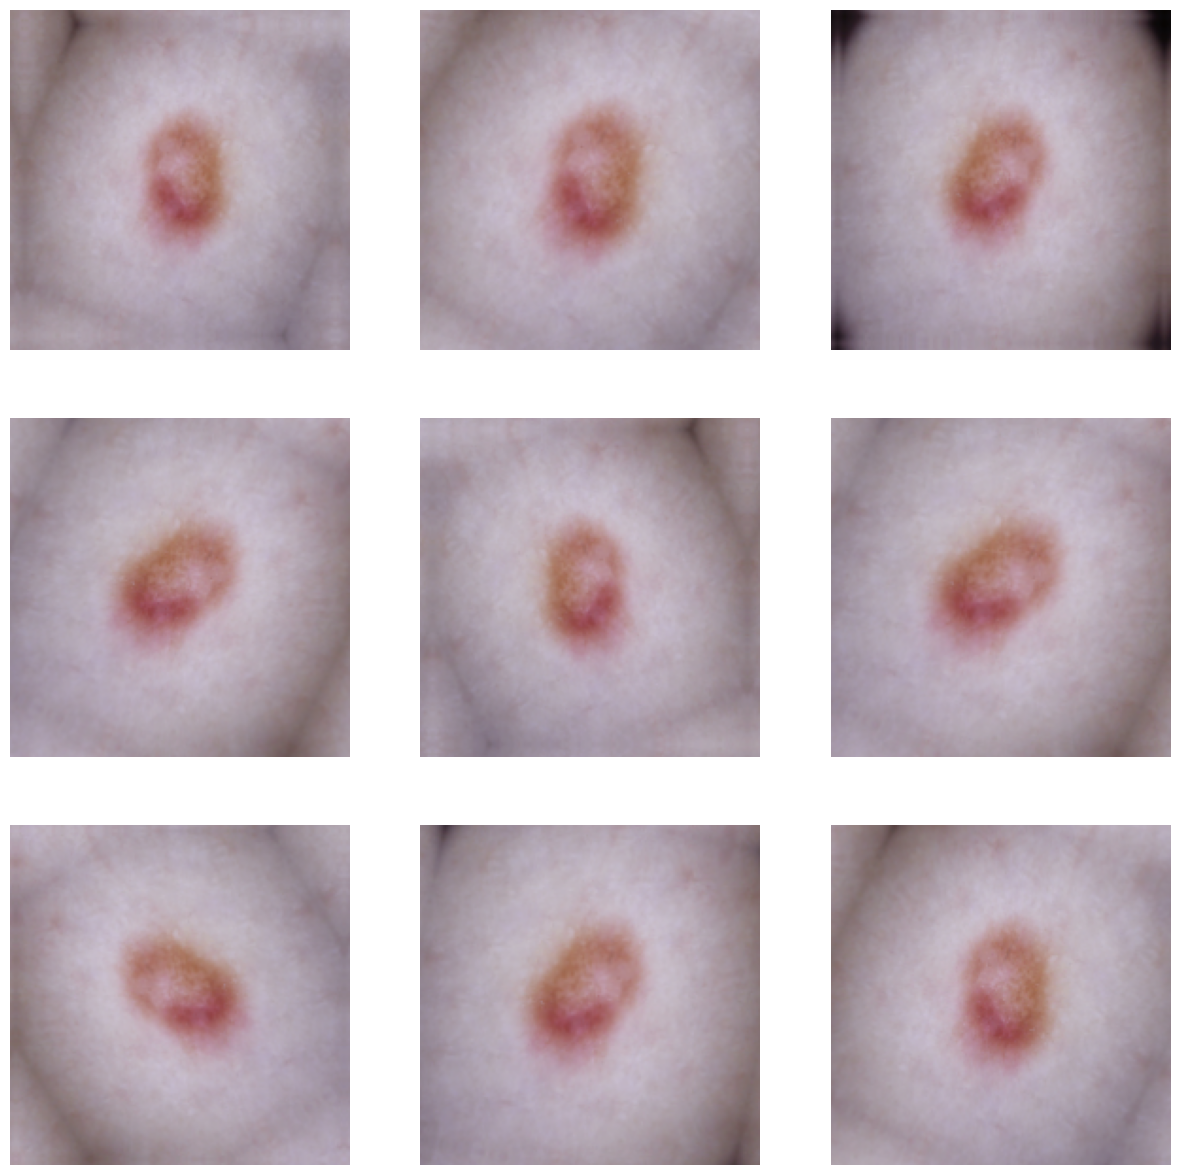

In [23]:
# visualizing the augmentation strategy for one instance of a training image.
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

Now, using this augmented data, let's come up with a new model

In [24]:
# CNN Model with data augmentation
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [25]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

In [26]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 62ms/step - loss: 2.1043 - accuracy: 0.2137 - val_loss: 1.9253 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 3s 62ms/step - loss: 1.7882 - accuracy: 0.3538 - val_loss: 1.7262 - val_accuracy: 0.3691
Epoch 3/20
56/56 [==============================] - 3s 62ms/step - loss: 1.6063 - accuracy: 0.4336 - val_loss: 1.5230 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 3s 59ms/step - loss: 1.4722 - accuracy: 0.4777 - val_loss: 1.4110 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 1.4267 - accuracy: 0.4967 - val_loss: 1.4009 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 3s 61ms/step - loss: 1.3279 - accuracy: 0.5279 - val_loss: 1.4259 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 1.3151 - accuracy: 0.5402 - val_loss: 1.3479 - val_accuracy: 0.5168
Epoch 8/20
56

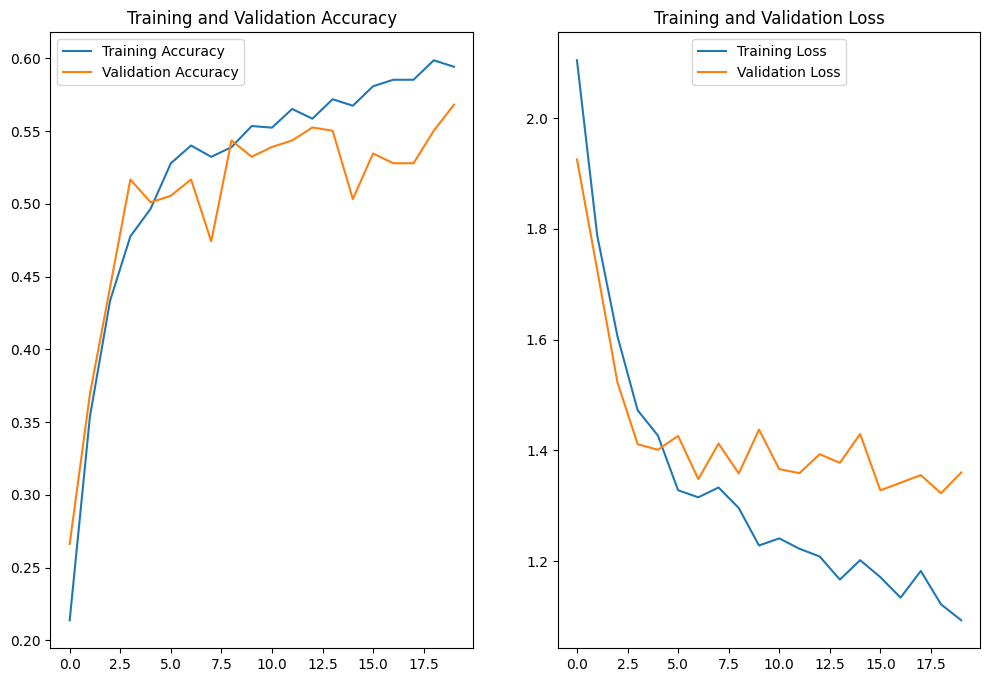

In [27]:
#visualize the results of our model after the data augmentation
visualize_cnn(history, epochs)

#### Observation

1. It can be observed that the gap between the training accuracy and the validation accuracy is much less now when compared to the initial model.
2. The same can be observed with the training loss and the validation loss.
3. The overall accuracy also looks improved but only by a little.
4. This implies that the <mark>**overfitting of the model is greatly reduced**</mark> when compared to the initial model but <mark>the overall accuracy isn't really great.</mark>

#### Class Distribution

Let's check the class distribution to see if all the classes(cancer types) are equally distributed

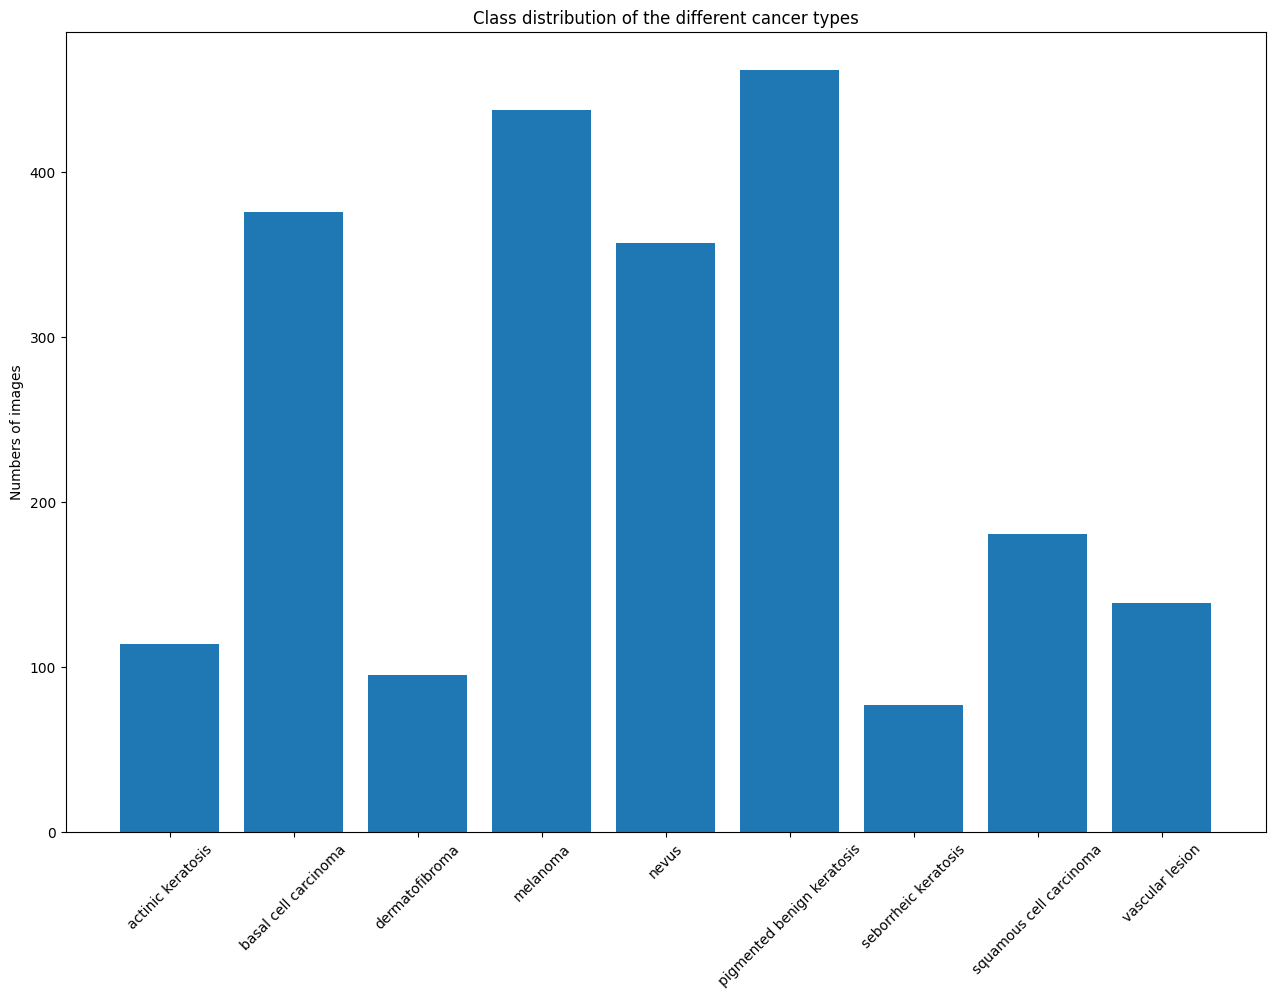

In [28]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

In [29]:
print("Number of samples for each class: ")
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

Number of samples for each class: 
actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


#### Observation

1. Class imbalance is observed. It can be seen that some classes have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality.
2. <mark>The class ***seborrheic keratosis*** has the least number of samples with just 77 images.</mark>
3. <mark>The class ***pigmented benign keratosis*** has the highest number of samples with 462 images.</mark>

To rectify this class imbalance, Augmentor library can be used to artificially generate newer samples.

In [30]:
#Install Augmentor
!pip install Augmentor

In [31]:
path_to_training_dataset="./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78305CDE9B70>: 100%|██████████| 500/500 [00:22<00:00, 21.74 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78305CC57850>: 100%|██████████| 500/500 [00:27<00:00, 18.49 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78310610D390>: 100%|██████████| 500/500 [00:26<00:00, 18.73 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78305D439750>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x78305D54F4F0>: 100%|██████████| 500/500 [01:14<00:00,  6.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x783057F0FA90>: 100%|██████████| 500/500 [00:19<00:00, 26.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78305D439540>: 100%|██████████| 500/500 [00:38<00:00, 13.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78305D43A560>: 100%|██████████| 500/500 [00:17<00:00, 28.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma_detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78305D439540>: 100%|██████████| 500/500 [00:19<00:00, 26.07 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
data_dir_train = pathlib.Path("./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Newly generated images with the Augmentor library:", image_count_train)

Newly generated images with the Augmentor library: 4500


Lets see the distribution of augmented data after adding new images to the original training data.

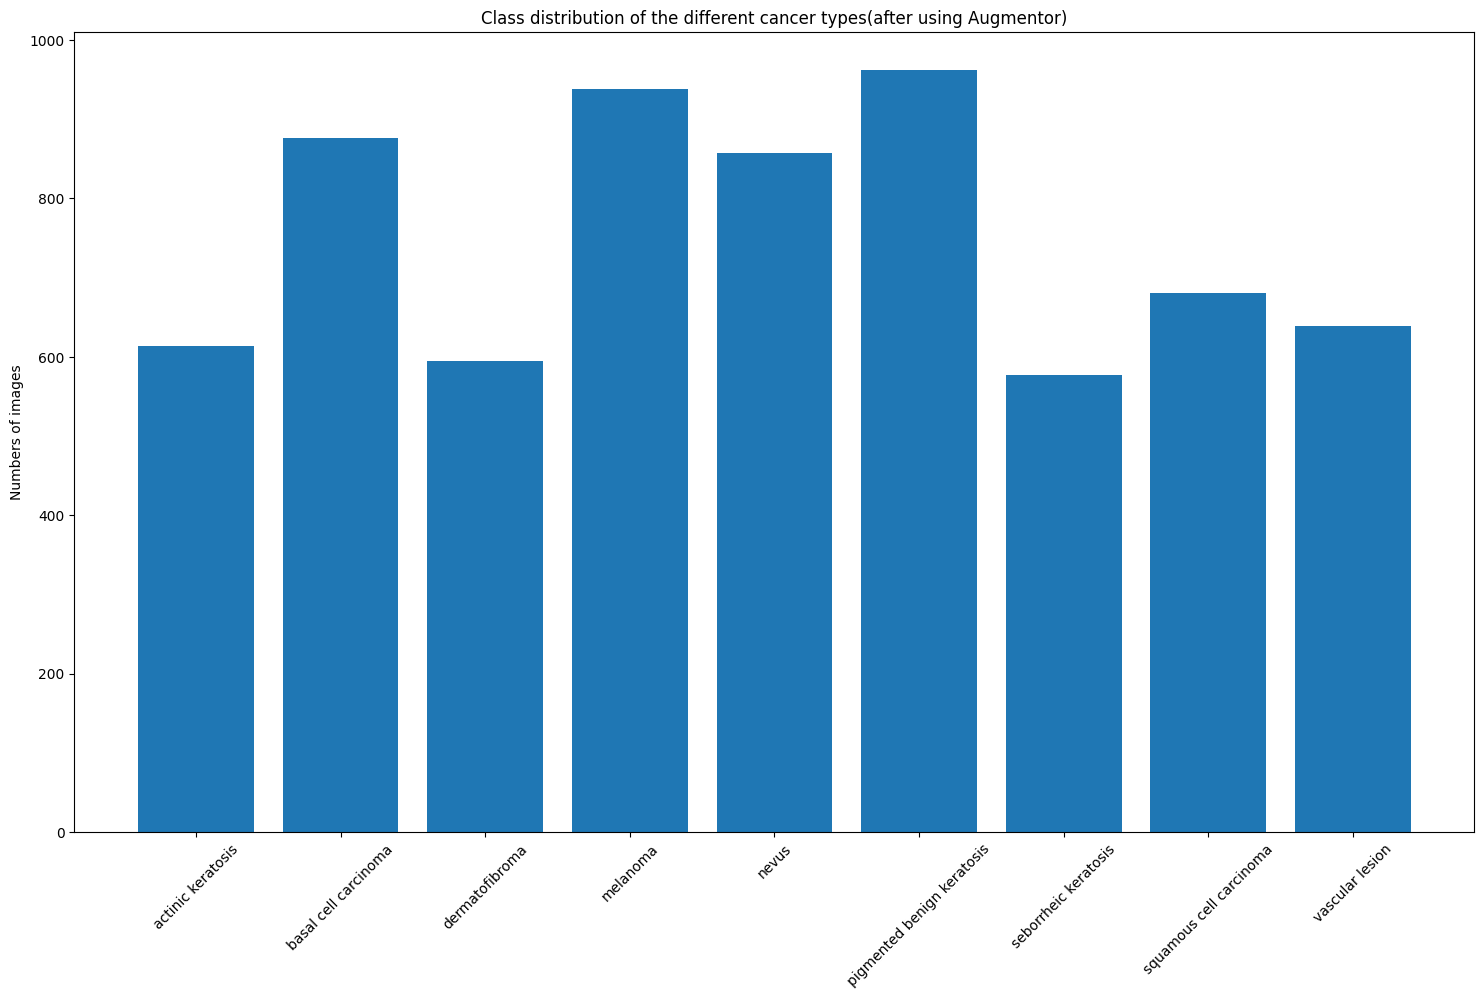

In [34]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) + len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=45)
plt.show()

#### Observation:

We have added 500 images to all the classes to maintain some class balance. Thus, now there are enough samples to analyze our model.

Let's create a training and validation dataset with our new samples

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_val,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_val,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Train the model on the data created using Augmentor

In [38]:
# CNN Model on the data created using Augmentor
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [39]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

In [40]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 46s 102ms/step - loss: 1.9737 - accuracy: 0.2407 - val_loss: 1.7541 - val_accuracy: 0.3103
Epoch 2/20
169/169 [==============================] - 10s 59ms/step - loss: 1.5375 - accuracy: 0.4282 - val_loss: 1.4932 - val_accuracy: 0.4365
Epoch 3/20
169/169 [==============================] - 10s 59ms/step - loss: 1.3071 - accuracy: 0.5143 - val_loss: 1.1988 - val_accuracy: 0.5501
Epoch 4/20
169/169 [==============================] - 10s 59ms/step - loss: 1.1413 - accuracy: 0.5746 - val_loss: 1.0743 - val_accuracy: 0.5924
Epoch 5/20
169/169 [==============================] - 10s 58ms/step - loss: 1.0167 - accuracy: 0.6205 - val_loss: 1.0320 - val_accuracy: 0.6095
Epoch 6/20
169/169 [==============================] - 10s 58ms/step - loss: 0.8955 - accuracy: 0.6703 - val_loss: 0.9218 - val_accuracy: 0.6652
Epoch 7/20
169/169 [==============================] - 10s 58ms/step - loss: 0.7403 - accuracy: 0.7222 - val_loss: 0.8093 - val_accuracy

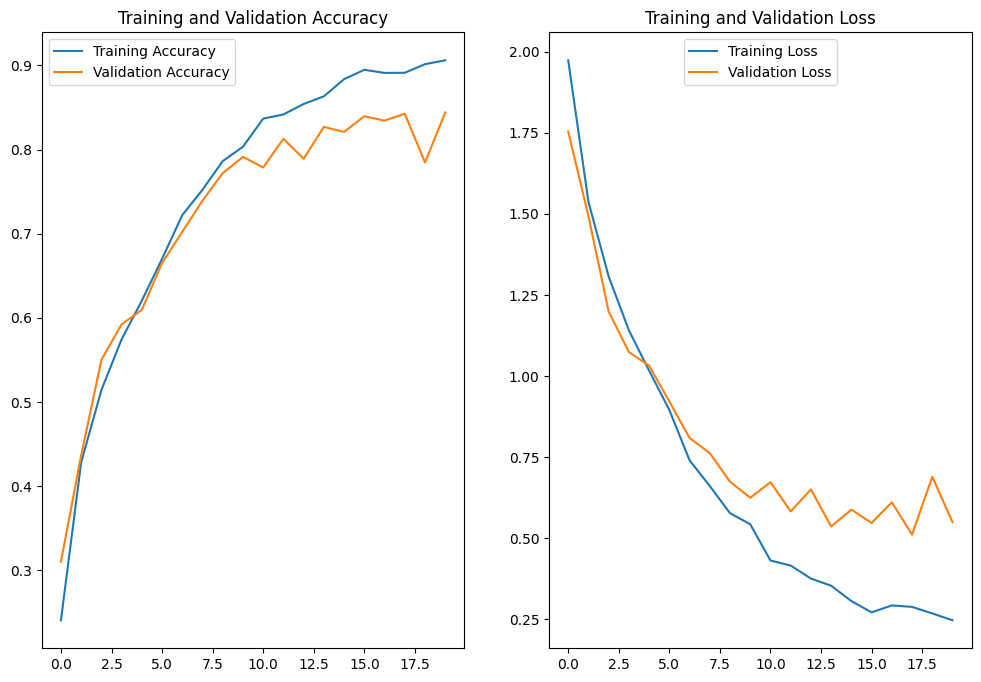

In [41]:
#visualize the results of model
visualize_cnn(history, epochs)

### Observation

1. With the increase in the training accuracy over time, where as the validation accuracy also increases.
2. The validation loss also decreases over time.
3. The gap between training accuracy and validation accuracy has decreased significantly compared to the previous model, and it has achieved around 84% accuracy on the validation set.


Finally, <mark>**Class rebalancing improved the overall accuracy and also reduced the overall loss**.</mark>